In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

import load_data as load
from models.model import Model
from models.customlayers import *
from models.activations import *
from training import *

import moviepy.editor as mpe
from models.AELSTM import *
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Insight/video-representations/frames')

In [3]:
training_epochs = 10
batchsize = 4
sequence_length = 64

model = Model(encoder, lstm_cell, decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, training_epochs)

encoded, transitioned, decoded = model.build(training_inputs)    # discard decoder here
loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))

optimizer = tf.train.AdamOptimizer()
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)    # clip those uglies
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, transitioned_validation, decoded_validation = model.build(validation_inputs, reuse=True)
targeted_validation = model.build_target_encoder(validation_targets, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

In [4]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    transitions = []
    validation_predictions = []
    validation_transitions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, trans, pred, input_recover = sesh.run(
                [train_step, loss, encoded, transitioned, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                print(step, loss_value)
                encodings.append(enc)
                transitions.append(trans)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, enc, trans, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, transitioned_validation, 
                 decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_transitions.append(trans)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm')
    

0 11986.7
250 4042.67
500 2793.53
750 2125.74
1000 1633.41
1250 1438.24
1500 2393.27
1750 2072.54
2000 2465.47
2250 1975.53
2500 1391.98
2750 1811.99
3000 1730.34
3250 1738.62
3500 1255.21
3750 1089.03
4000 2254.2
4250 1493.13
4500 1700.49
4750 1995.18
5000 1244.57
5250 1372.68
5500 944.866
5750 725.929
6000 1100.37
6250 1661.29
6500 984.103
6750 1605.84
7000 1685.6
7250 1389.21
7500 1694.43
7750 824.17
8000 1522.36
8250 1411.57
8500 1987.66
8750 2097.28
9000 2045.35
9250 1336.58
9500 1111.97
9750 1138.72
10000 1145.7
10250 1913.06
10500 1702.19
10750 1875.87
11000 1383.15
11250 1184.87
11500 1439.15
11750 2180.11
12000 1717.48
12250 1266.66
12500 880.351
12750 1006.68
13000 1330.68
13250 1608.1
13500 1505.58
13750 1932.83
14000 938.492
14250 1793.22
14500 921.326
14750 1026.11
15000 774.437
15250 1308.44
15500 1199.18
15750 1818.36
16000 1122.31
16250 1361.28
16500 1191.13
16750 1126.1
17000 1563.45
17250 1419.47
17500 1597.98
17750 1030.0
18000 1119.03
18250 917.305
18500 1077.39
187

ValueError: need more than 5 values to unpack

[0, 2000]

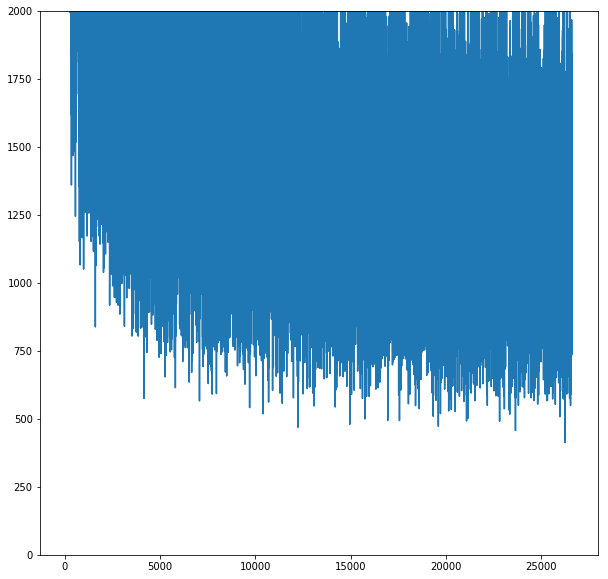

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.plot(decoder_losses)
plt.setp(axes, ylim=[0, 2000])


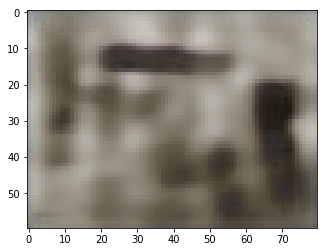

In [41]:
plt.imshow(np.minimum(np.maximum(predictions[-10][0, 3, :, :, :], 0), 255) / 255)

In [31]:
encodings[-1][0].min()

-1.7580993

In [28]:
transitions[-1][0].max()

63241.562

In [43]:
from render import render_movie

frame_array = render_movie(recovery[-1][0], 'test_lstm_recov.mp4', 5)

[MoviePy] >>>> Building video test_lstm_recov.mp4
[MoviePy] Writing video test_lstm_recov.mp4


100%|██████████| 64/64 [00:00<00:00, 3104.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_lstm_recov.mp4 

